# Fill Missing Soil Moisture Timeseries

Once in a while we handle a dataset containing missing values. Interpolation can help us to fill in some of these gaps. Interpolation can also be used to estimate values between observations without the need for collecting or storing more data.

Using a daily dataset of weather data for the Kansas Mesonet located near Gypsum, KS we will fill few missing observation of air temperature and then we will create an hourly timeseries of volumetric water content from a daily timeseries using multiple one-dimensional interpolation methods.


In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [137]:
df = pd.read_csv("../datasets/gypsum_ks_daily_2018.csv")
df.head()


,TIMESTAMP,STATION,PRESSUREAVG,PRESSUREMAX,PRESSUREMIN,SLPAVG,TEMP2MAVG,TEMP2MMIN,TEMP2MMAX,TEMP10MAVG,...,SOILTMP10MAX,SOILTMP10MIN,SOILTMP5AVG655,SOILTMP10AVG655,SOILTMP20AVG655,SOILTMP50AVG655,VWC5CM,VWC10CM,VWC20CM,VWC50CM
0,1/1/18 0:00,Gypsum,99.44,100.03,98.73,104.44,-15.15,-19.56,-11.00,-15.31,...,-1.18,-2.45,-1.33,-1.14,0.74,3.50,0.1377,0.1167,0.2665,0.2203
1,1/2/18 0:00,Gypsum,99.79,100.14,99.40,104.88,-16.48,-22.10,-10.40,-16.38,...,-1.56,-3.46,-2.10,-1.82,0.28,3.13,0.1234,0.1021,0.2642,0.2196
2,1/3/18 0:00,Gypsum,98.87,99.52,97.94,103.81,-11.03,-20.64,-2.71,-10.66,...,-1.49,-3.61,-2.21,-1.93,-0.08,2.76,0.1206,0.0965,0.2353,0.2189
3,1/4/18 0:00,Gypsum,98.22,98.54,97.90,102.99,-5.83,-11.79,0.24,-5.01,...,-0.98,-2.67,-1.60,-1.46,-0.21,2.45,0.1235,0.0973,0.2094,0.2182
4,1/5/18 0:00,Gypsum,98.10,98.42,97.75,102.88,-4.73,-14.22,5.36,-4.23,...,-0.72,-2.81,-1.54,-1.38,-0.25,2.25,0.1249,0.0976,0.2047,0.2180


In [138]:
df.isna().sum()

TIMESTAMP          0
STATION            0
PRESSUREAVG        0
PRESSUREMAX        0
PRESSUREMIN        0
SLPAVG             0
TEMP2MAVG          1
TEMP2MMIN          1
TEMP2MMAX          2
TEMP10MAVG         0
TEMP10MMIN         1
TEMP10MMAX         2
RELHUM2MAVG        0
RELHUM2MMAX        0
RELHUM2MMIN        1
RELHUM10MAVG       0
RELHUM10MMAX       0
RELHUM10MMIN       1
VPDEFAVG           1
PRECIP             0
SRAVG              0
SR                 0
WSPD2MAVG          0
WSPD2MMAX          0
WSPD10MAVG         0
WSPD10MMAX         0
WDIR2M             0
WDIR2MSTD          0
WDIR10M            0
WDIR10MSTD         0
SOILTMP5AVG        0
SOILTMP5MAX        0
SOILTMP5MIN        0
SOILTMP10AVG       0
SOILTMP10MAX       0
SOILTMP10MIN       0
SOILTMP5AVG655     0
SOILTMP10AVG655    0
SOILTMP20AVG655    0
SOILTMP50AVG655    0
VWC5CM             0
VWC10CM            0
VWC20CM            0
VWC50CM            0
dtype: int64

In [139]:
# Get position of missing max air temperature at 2-m height
idx = df["TEMP2MMAX"].isna()
df.loc[idx,"TEMP2MMAX"]


178   NaN
263   NaN
Name: TEMP2MMAX, dtype: float64

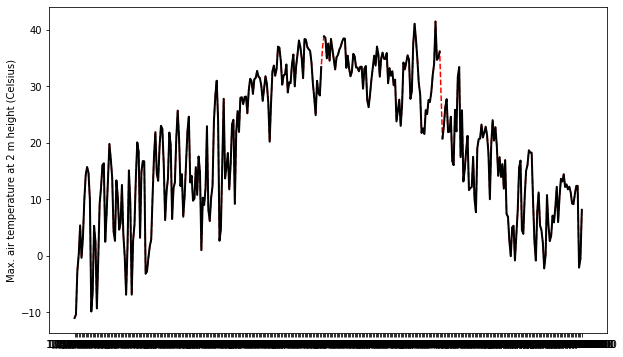

In [140]:
# Interpolate missing data
plt.figure(figsize=(10,6))
plt.plot(df["TIMESTAMP"], df["TEMP2MMAX"].interpolate(method='polynomial', order=2), '--r')
plt.plot(df["TIMESTAMP"], df["TEMP2MMAX"], '-k', linewidth=2)
plt.ylabel('Max. air temperature at 2 m height (Celsius)')
plt.show()


## Daily to hourly data


In [141]:
# Convert date strings to pandas datetime format
df["TIMESTAMP"] = pd.to_datetime(df["TIMESTAMP"], format="%m/%d/%y %H:%M")


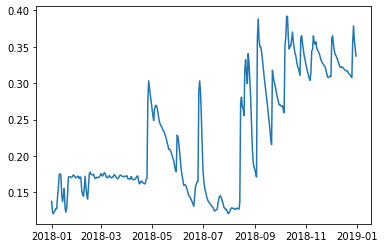

In [142]:
# Inspect data
plt.plot(df["TIMESTAMP"], df["VWC5CM"])
plt.show()


When we use the `plot` command the library automatically connects consecutive points. In reality, individual observations should be represented using a scatter plot.


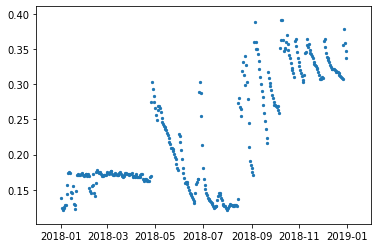

In [143]:
plt.scatter(df["TIMESTAMP"], df["VWC5CM"], s=5)
plt.show()

For most applications daily time steps are adequate and either plot will suffice our objectives. But what if we need to estimate the sub-daily soil moisture based on daily values. Can we fill these gaps by interpolating the data? Can we use the same technique to fill in the gaps left by missing observations?


In [152]:
df_hourly = pd.DataFrame()
df_hourly["TIMESTAMP"] = pd.date_range(start=df["TIMESTAMP"].iloc[0], end=df["TIMESTAMP"].iloc[-1], freq='H')
df_hourly.head()


,TIMESTAMP
0,2018-01-01 00:00:00
1,2018-01-01 01:00:00
2,2018-01-01 02:00:00
3,2018-01-01 03:00:00
4,2018-01-01 04:00:00


In [153]:
print("Daily dataframe: ", df["TIMESTAMP"].iloc[0])
print("Daily dataframe: ", df["TIMESTAMP"].iloc[-1])

print("Hourly dataframe: ", df_hourly["TIMESTAMP"].iloc[0])
print("Hourly dataframe: ", df_hourly["TIMESTAMP"].iloc[-1])

Daily dataframe:  2018-01-01 00:00:00
Daily dataframe:  2018-12-31 00:00:00
Hourly dataframe:  2018-01-01 00:00:00
Hourly dataframe:  2018-12-31 00:00:00


In [154]:
idx_timestamp = df_hourly["TIMESTAMP"].isin(df["TIMESTAMP"])
print(idx_timestamp.shape)
idx_timestamp


(8737,)


0        True
1       False
2       False
3       False
4       False
        ...  
8732    False
8733    False
8734    False
8735    False
8736     True
Name: TIMESTAMP, Length: 8737, dtype: bool

In [155]:
df_hourly["VWC5CM"] = np.nan
df_hourly.head()


,TIMESTAMP,VWC5CM
0,2018-01-01 00:00:00,NaN
1,2018-01-01 01:00:00,NaN
2,2018-01-01 02:00:00,NaN
3,2018-01-01 03:00:00,NaN
4,2018-01-01 04:00:00,NaN


In [159]:
#df_hourly.loc[idx_timestamp,"VWC5CM"] = df["VWC5CM"]

#df_hourly = df_hourly.merge(df, how='left', left_on='TIMESTAMP', right_on='TIMESTAMP')
#df_hourly.head(50)

for i in range(df.shape[0]):
    for j in range(df_hourly.shape[0]):
        if df["TIMESTAMP"][i] == df_hourly["TIMESTAMP"][j]:
            df_hourly["VWC5CM"].iloc[j] = df["VWC5CM"].iloc[i]
            

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [161]:
df_hourly["VWC5CM_linear"] = df_hourly["VWC5CM"].interpolate(method='linear')
df_hourly["VWC5CM_poly2"] = df_hourly["VWC5CM"].interpolate(method='polynomial', order=2)
df_hourly["VWC5CM_pchip"] = df_hourly["VWC5CM"].interpolate(method='pchip')
df_hourly


,TIMESTAMP,VWC5CM,VWC5CM_linear,VWC5CM_poly2,VWC5CM_pchip
0,2018-01-01 00:00:00,0.1377,0.137700,0.137700,0.137700
1,2018-01-01 01:00:00,NaN,0.137104,0.136859,0.136868
2,2018-01-01 02:00:00,NaN,0.136508,0.136040,0.136044
3,2018-01-01 03:00:00,NaN,0.135912,0.135242,0.135231
4,2018-01-01 04:00:00,NaN,0.135317,0.134465,0.134429
...,...,...,...,...,...
8732,2018-12-30 20:00:00,NaN,0.339033,0.339185,0.338985
8733,2018-12-30 21:00:00,NaN,0.338600,0.338720,0.338562
8734,2018-12-30 22:00:00,NaN,0.338167,0.338250,0.338140
8735,2018-12-30 23:00:00,NaN,0.337733,0.337777,0.337719


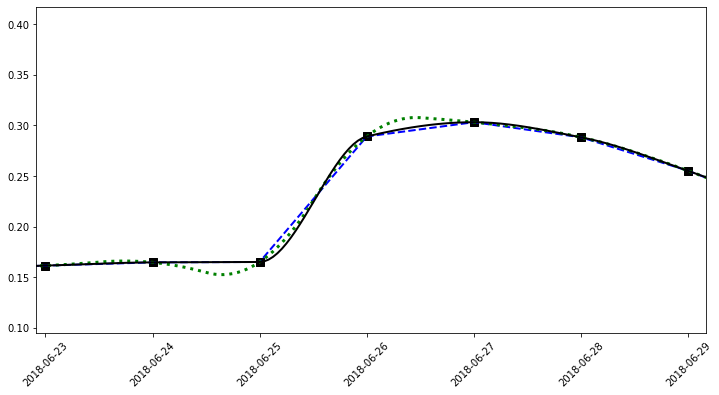

In [227]:
plt.figure(figsize=(12,6))
plt.scatter(df["TIMESTAMP"],df["VWC5CM"], marker='s', s=50, facecolor='k')
plt.plot(df_hourly["TIMESTAMP"], df_hourly["VWC5CM_linear"], '--b', alpha=1, linewidth=2)
plt.plot(df_hourly["TIMESTAMP"], df_hourly["VWC5CM_poly2"], ':g', alpha=1, linewidth=3)
plt.plot(df_hourly["TIMESTAMP"], df_hourly["VWC5CM_pchip"], '-k', alpha=1, linewidth=2)
#plt.scatter(df_hourly["TIMESTAMP"], df_hourly["VWC5CM_linear"], marker='+', s=40, alpha=1)

plt.xlim(df_hourly["TIMESTAMP"].iloc[4150], df_hourly["TIMESTAMP"].iloc[4300])
plt.xticks(rotation=45)
plt.show()
